In [6]:
import math
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prettytable import PrettyTable
from os import listdir
from sklearn.metrics import f1_score
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [7]:
os.chdir('/Users/Indy/Desktop/coding/Dementia_proj/src/ddc')

In [8]:
%run preprocessing.ipynb

In [9]:
mypath = '../../DDC_Data/raw/'
basepath = '../../'

# Get the Actual Timestamp Labels

In [10]:
def load_timer(subject_id):
    
    sid_dir = mypath + subject_id
    sid_files = [f for f in listdir(sid_dir) if 'history_amdtimer' in f]

    sid_filepath = sid_dir + '/' + sid_files[0]

    timer_df = pd.read_csv(sid_filepath, header=None, names=['sid','raw_label', 'timestamp', 'duration','label'])

    filtered_timer = [i for i in timer_df['sid'] if i==int(subject_id)]

    timer_filt = timer_df[timer_df['sid'].isin(filtered_timer)]
    timer_filt = timer_filt.reset_index(drop=True)
    
    timer_label = []
    
    for i in range(len(timer_filt)):
        if(timer_filt.loc[i]['raw_label']=='upstairs' or 
          timer_filt.loc[i]['raw_label']=='downstairs'):
            timer_label.append('walk')
        else:
            timer_label.append(timer_filt.loc[i]['raw_label'])

    timer_filt['label'] = pd.Series(timer_label)
    
    datetime_format = '%Y-%m-%d %H:%M:%S.%f'
    timer_filt['time_start'] = timer_filt['timestamp'].apply(lambda x: datetime.strptime(x, datetime_format))
    
    time_format = '%H:%M:%S'
    zero_date = datetime(1900, 1, 1)
    
    timer_filt['duration'] = timer_filt['duration'].apply(lambda x: datetime.strptime(x, time_format)-zero_date)
    
    for i in range(timer_filt.shape[0]):
        timer_filt.loc[i, 'time_end'] = timer_filt.loc[i, 'time_start'] + timer_filt.loc[i, 'duration']

#     print(timer_filt)
    
    return timer_filt

# Load Data of the Subject

In [11]:
def load_acc(subject_id, start_time, end_time):
    # Load accelerations
    acc_path = mypath + '/' + subject_id + '/' + subject_id + '-log_acc.csv'

    df = pd.read_csv(acc_path, header=None, names=['x','y','z','timestamp'])
    
    datetime_format = '%Y-%m-%d %H:%M:%S.%f'
    df['timestamp'] = df['timestamp'].apply(lambda x: datetime.strptime(x, datetime_format))

    filtered = [r for r in df['timestamp'] if r>=start_time and r<=end_time]

    df_filt = df[df['timestamp'].isin(filtered)]
    df_filt = df_filt.reset_index(drop=True)

    df_filt['ID'] = pd.Series([subject_id for i in range(len(df_filt))])
    
    cols = ['ID','timestamp','x','y','z']
    df_filt = df_filt[cols]

    return df_filt

In [12]:
def load_hr(subject_id, start_time, end_time):
    # Load heart rate
    hr_filepath = mypath + '/' + subject_id + '/' + subject_id + '-log_hr.csv'

    df2 = pd.read_csv(hr_filepath, header=None, names=['hr','timestamp'])
    
    datetime_format = '%Y-%m-%d %H:%M:%S.%f'
    df2['timestamp'] = df2['timestamp'].apply(lambda x: datetime.strptime(x, datetime_format))

    filtered = [r for r in df2['timestamp'] if r>=start_time and r<=end_time]

    df_hr = df2[df2['timestamp'].isin(filtered)]
    df_hr = df_hr.reset_index(drop=True)

    cols = ['timestamp','hr']
    df_hr = df_hr[cols]

    return df_hr

In [13]:
def merge_acc_and_hr(df_filt, df_hr):
    # Fill in missing HRs
    hr_cnt = 0

    for i in range(len(df_filt)):
        hr_time = df_hr.loc[hr_cnt,'timestamp']
        filt_time = df_filt.loc[i,'timestamp']

        if(hr_time<=filt_time):
            if(hr_cnt<len(df_hr)-1):
                hr_cnt += 1
        df_filt.loc[i,'HR'] = df_hr.loc[hr_cnt,'hr']

    # Normalize by dividing by g (standard gravity)
    g = 9.8
    df_filt.loc[:,'x'] = df_filt['x'].apply(lambda x: x/g)
    df_filt.loc[:,'y'] = df_filt['y'].apply(lambda x: x/g)
    df_filt.loc[:,'z'] = df_filt['z'].apply(lambda x: x/g)
    
    cols = ['x','y','z']
    xyz_ = df_filt[cols].to_dict('split')['data']
    xyz_new = MinMaxScaler().fit_transform(xyz_)

    for i in range(len(cols)):
        df_filt[cols[i]] = pd.Series(xyz_new.transpose()[i])
        
#     print(df_filt['x'])

    return df_filt

# Calculate Activity Index

In [14]:
std_i_bar = [0.00349329,0.00465817,0.00543154]
std_i_bar = np.array(std_i_bar)

In [15]:
def equation_bai(X_i):
    all_std = []
    
    std_i = np.std(X_i,axis=0)
    diff_std = std_i**2 - std_i_bar**2
    diff_std = (diff_std + 1) / (std_i_bar**2 + 1)
    
    diff_std_ = std_i**2

    all_std.append(diff_std)
    
    all_std = np.array(all_std)
    
    ai = np.sum(all_std**2,axis=1)/3
    ai[ai<0] = 0
    ai = np.sqrt(ai)
    
    return ai

In [16]:
def calc_ai(df1):
    H = 10
    ai1 = []

    for i in range(len(df1)):
        xyz_val = []
        if(i-H>=0):
            for j in range(H,0,-1):
                xyz_val.append([df1.loc[i-j,'x'],df1.loc[i-j,'y'],df1.loc[i-j,'z']])
            ai_val = float(equation_bai(xyz_val))
            ai1.append(ai_val)
        else:
            ai1.append(1)

    return ai1

# Preprocess (PCA + impure)

In [17]:
def preprocess_data(df_test, pca):
    ts_list = []
    g = 9.8

    X_list = []
    
    for i in range(len(df_test)):
        X_i = [df_test.loc[i]['x']/g, df_test.loc[i]['y']/g, df_test.loc[i]['z']/g]
        X_list.append(X_i)
        
    X_stack = np.vstack(X_list)
    X_norm = MinMaxScaler().fit_transform(X_stack)
    X_pca = pca.transform(X_norm)

    y_imp = [-1 for i in range(X_pca.shape[0])]
    X_imp, y_imp = prepare_impure_label(X_pca, y_imp)
    
    return X_imp, y_imp

# Predict

In [18]:
%run classifier_algo.ipynb

In [19]:
def predict_combine(X_imp, model, window_length=60):
    
    y_pred = model.predict(X_imp)
    print("Finished prediction")
    
#     y_pred = combine_2(X_imp, y_pred)
#     y_pred_fill = np.hstack(([y_pred[0] for i in range(window_length-1)], y_pred))
    
#     print(X_imp.shape, y_pred_fill.shape)
    
    return y_pred

# Group dataframe by label

In [20]:
def group_dataframe_by_label(df1, df_timer, subject_id, label_list):
    df_list = {}
    period = {}
    
    for label in label_list:
        df_list[label] = pd.DataFrame()
        period[label] = []
    
    for label in label_list:
#         print(label)
        for i in range(df_timer.shape[0]):
            start = 0
            end = 0
            
            if(df_timer.loc[i, 'label']==label):
                t_a = df_timer.loc[i, 'time_start']
                t_b = df_timer.loc[i, 'time_end']

                for j in range(df1.shape[0]):    
                    if(df1.loc[j, 'ID']==subject_id):
                        if(j>0 and df1.loc[j, 'timestamp']<=t_b and df1.loc[j-1, 'timestamp']<t_b):
                            end = j

                for j in reversed(range(df1.shape[0])):
                    if(df1.loc[j, 'ID']==subject_id):
                        if(j<df1.shape[0]-1 and df1.loc[j, 'timestamp']>=t_a and df1.loc[j+1, 'timestamp']>t_a):
                            start = j

                period[label].append([start, end])
                
                if(df_list[label].empty):
#                     print('intiate')
                    df_list[label] = df1.loc[start:end+1]
                else:
#                     print('append')
                    df_list[label] = df_list[label].append(df1.loc[start:end+1], ignore_index=True)
                    
    for label in label_list:
        df_list[label] = df_list[label].reset_index(drop=True)

    return df_list, period

# Prepare Predicted Labels

In [21]:
def get_periods_from_list(y_pred, label_list):
    
    pred_periods = [[] for i in range(len(label_list))]

    keep = 0

    for i in range(len(y_pred)):
        keep_lb = y_pred[keep]

        if(keep_lb!=y_pred[i]):
            
            if(y_pred[i]!=None):
                pred_periods[y_pred[i-1]].append([keep, i-1])               

            keep = i

        elif(i==len(y_pred)-1):

            if(y_pred[i]!=None):
                pred_periods[y_pred[i-1]].append([keep, i]) 

    pred_periods = np.array(pred_periods)
    
    return pred_periods

### Unused

In [22]:
def postprocess_predicted(pred_periods, y_length):
    onesec = 1  # 1 sec.
    T = 0.16    # T = 1/f

    pp_periods = []
    
    for pp in pred_periods:
        pp_i = pred_periods[pp]
        
        temp = []
        for p in pp_i:
            if(p[1]-p[0]>int(onesec*2*(1/T))):
                temp.append([p[0],p[1]])
                
        pp_periods.append(temp)

    pp_periods = np.array(pp_periods)
    
    other_label = -1
    all_run = [other_label for i in range(y_length)]

    for i in range(len(pp_periods)):
        for p in pp_periods[i]:
            for j in range(p[0],p[1]+1):
                all_run[j] = i

    for i in range(len(all_run)-1,0,-1):
        if(all_run[i-1]==other_label):
            all_run[i-1] = all_run[i]

    return all_run

# Get sequence from periods

In [23]:
def sequence_from_periods(periods, label_list):
    
    max_length = 0
    
    for label in label_list:
        if(len(periods[label])>0):
            periods_i = np.hstack(periods[label])
        
            if(max_length<max(periods_i)):
                max_length = max(periods_i)
    
    seq = ['' for i in range(max_length+1)]
    
    for label in label_list:
        for element in periods[label]:
            for i in range(element[0], element[1]+1):
                seq[i] = label
    
    return seq, max_length

# Evaluation

In [24]:
def evaluate_period(p1, p2, max_length, label_list):
    iou_all = []
    
    for lb in label_list:
        p1_onehot = []
        for i in range(max_length):
            if(p1[i]==lb):
                p1_onehot.append(1)
            else:
                p1_onehot.append(0)
                
        p2_onehot = []
        for i in range(max_length):
            if(p2[i]==lb):
                p2_onehot.append(1)
            else:
                p2_onehot.append(0)
                
        intersection = 0
        union = 0
        
        for i in range(max_length):
            if(p1_onehot[i]==1 and p2_onehot[i]==1):
                intersection += 1
            if(p1_onehot[i]==1 or p2_onehot[i]==1):
                union += 1
                
        iou_lb = intersection/union
        
        iou_all.append(iou_lb)
        
    return iou_all

# Load all data

In [25]:
def load_all_data(subject_id, label_list):
    
    print("Loading {0}'s data".format(subject_id))

    df_timer = load_timer(subject_id)
    
    start_time = df_timer.loc[0, 'time_start']
    end_time = df_timer.loc[df_timer.shape[0]-1, 'time_end']

    df_acc = load_acc(subject_id, start_time, end_time)
    df_hr = load_hr(subject_id, start_time, end_time)

    df1 = merge_acc_and_hr(df_acc, df_hr)
    ai1 = calc_ai(df1)

    df1['AI'] = pd.Series(ai1)
    
    df_acc_label, true_periods = group_dataframe_by_label(df1, df_timer, subject_id, label_list)
    
    return df_acc_label, true_periods

In [76]:
all_subjects = [range(1001, 1017)]  # , range(3001, 3006)]
all_subjects = np.hstack(all_subjects)
all_subjects = [str(i) for i in all_subjects]
print(all_subjects)

label_list = ['sit', 'sleep', 'stand', 'walk']

df_all_label = {}
for label in label_list:
    df_all_label[label] = pd.DataFrame()
# print(df_all_label)

for subject_id in all_subjects:
    df_label, true_periods = load_all_data(subject_id, label_list)
    
    for label in label_list:
        
        if(df_all_label[label].empty):
            df_all_label[label] = df_label[label]
        else:
            df_all_label[label] = df_all_label[label].append(df_label[label], ignore_index=True)
            
        print(df_all_label[label].shape)
            
print('finished loading')

['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016']
{'sit': Empty DataFrame
Columns: []
Index: [], 'sleep': Empty DataFrame
Columns: []
Index: [], 'stand': Empty DataFrame
Columns: []
Index: [], 'walk': Empty DataFrame
Columns: []
Index: []}
Loading 1001's data
(376, 7)
(381, 7)
(556, 7)
(863, 7)
Loading 1002's data
(750, 7)
(751, 7)
(1119, 7)
(1577, 7)
Loading 1003's data
(1131, 7)
(1120, 7)
(1683, 7)
(2297, 7)
Loading 1004's data
(1513, 7)
(1307, 7)
(2203, 7)
(3042, 7)
Loading 1005's data
(1876, 7)
(1695, 7)
(2784, 7)
(3710, 7)
Loading 1006's data
(2264, 7)
(2088, 7)
(3353, 7)
(4437, 7)
Loading 1007's data
(2639, 7)
(2464, 7)
(3917, 7)
(5151, 7)
Loading 1008's data
(3014, 7)
(2840, 7)
(4480, 7)
(5902, 7)
Loading 1009's data
(3397, 7)
(3216, 7)
(5044, 7)
(6798, 7)
Loading 1010's data
(3773, 7)
(3599, 7)
(5608, 7)
(7506, 7)
Loading 1011's data
(4149, 7)
(3975, 7)
(6171, 7)
(8370, 7)
Loading 1012's data
(4525, 

# Slice dataframe to get all sequences

In [28]:
def slice_dataframe(df, sequence_length=60):
    df_list = []
    
    cols = ['x', 'y', 'z']
    for i in range(0, df.shape[0]-sequence_length, sequence_length):
        df_sequence = df.loc[i:i+sequence_length-1][cols]
        
        df_list.append(df_sequence.to_dict(orient='split')['data'])
        
    return np.array(df_list)

In [29]:
def get_df_sliced(df_all_label, label_list):
    df_sliced = {}
    slice_label = []

    for label in label_list:
        df_sliced[label] = slice_dataframe(df_all_label[label])
        slice_label.append([label for i in range(df_sliced[label].shape[0])])
    
    slice_label = np.hstack(slice_label)
        
    return df_sliced, np.array(slice_label)

# Get subsequences from all sequences

In [32]:
def get_subseq_for_each_axis(df_sliced, label_list, w=24):
    all_subseq = []
    for label in label_list:
        for slice_lbl in df_sliced[label]:
            for i in range(slice_lbl.shape[0]-w+1):
                all_subseq.append(slice_lbl[i:i+w])
            
    all_subseq = np.array(all_subseq)

    subseq_axes = {}
    axes = ['x', 'y', 'z']
    for ax in axes:
        subseq_axes[ax] = []

    for subseq_i in all_subseq:
        for i, ax in enumerate(axes):
            subseq_axes[ax].append(np.transpose(subseq_i)[i])
    
    for ax in axes:
        subseq_axes[ax] = np.array(subseq_axes[ax])
    
    return subseq_axes

# Create histogram for each sequence

In [35]:
def get_cluster_centers(subsequence_i):
    kmeans = KMeans(n_clusters=128, random_state=42).fit(subsequence_i)
    cluster_centers = kmeans.cluster_centers_
    
    return cluster_centers

In [37]:
def normalize(v):
    return v / np.linalg.norm(v) if np.linalg.norm(v)!=0 else v

In [38]:
def most_similar_codeword_idx(segment_i, all_codewords):
    min_dist = math.inf
    codeword_idx = 0
    for i, codeword_i in enumerate(all_codewords):
        dist_i = np.linalg.norm(codeword_i-segment_i)
        if(dist_i<min_dist):
            min_dist = dist_i
            codeword_idx = i
            
    return codeword_idx

In [44]:
def get_histogram(all_sequences, all_codewords, w=24):
    axes = ['x', 'y', 'z']
    
    blank_histogram = [0 for i in range(len(all_codewords['x']))]
    all_histograms = {}
    for ax in axes:
        all_histograms[ax] = []
    
    for a, ax in enumerate(axes):
        print(ax)
        for sequence_i in all_sequences:
            temp_histogram = blank_histogram

            for i in range(sequence_i.shape[0]-w+1):
                sequence_ax = np.transpose(sequence_i)[a]
                histogram_idx = most_similar_codeword_idx(sequence_ax[i:i+w], all_codewords[ax])
                temp_histogram[histogram_idx] += 1
        
            normalized_hist = normalize(temp_histogram)
            all_histograms[ax].append(normalized_hist)
    
    return all_histograms

In [48]:
def get_features(df_all_label, label_list):
    axes = ['x', 'y', 'z']

    df_sliced, all_labels = get_df_sliced(df_all_label, label_list)

    all_sequences = np.vstack([df_sliced[label] for label in label_list])
    all_subseq = get_subseq_for_each_axis(df_sliced, label_list)

    all_codewords = {}

    for ax in axes:
        print(ax)
        all_codewords[ax] = get_cluster_centers(all_subseq[ax])

    all_histograms = get_histogram(all_sequences, all_codewords)

    all_features = [[] for i in range(len(all_histograms['x']))]

    for ax in axes:
        for i, hist in enumerate(all_histograms[ax]):
            all_features[i].append(hist)

    for i in range(len(all_features)):
        all_features[i] = [item for sublist in all_features[i] for item in sublist]

    print(len(all_labels))
    print(len(all_features))
    print(len(all_features[0]))
    
    return all_features, all_labels, all_codewords

In [77]:
all_features, all_labels, all_codewords = get_features(df_all_label, label_list)

x
y
z
x
y
z
521
521
384


# Create a model using SVM

In [78]:
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.1, random_state=42)

In [79]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

468 53
468 53


In [80]:
svm_model = svm_classifier(X_train, y_train)
print("Finished training")

Finished training


In [81]:
y_pred = svm_model.predict(X_test)

In [82]:
%run eval_score.ipynb

0.9245283018867925


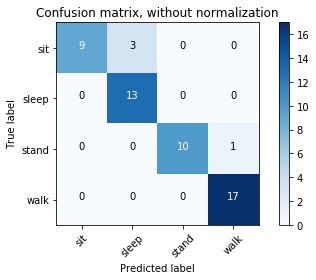

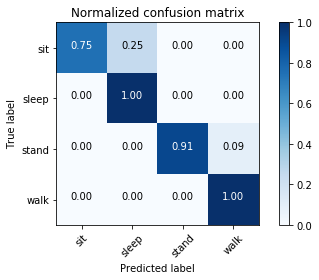

              precision    recall  f1-score   support

         sit       1.00      0.75      0.86        12
       sleep       0.81      1.00      0.90        13
       stand       1.00      0.91      0.95        11
        walk       0.94      1.00      0.97        17

   micro avg       0.92      0.92      0.92        53
   macro avg       0.94      0.91      0.92        53
weighted avg       0.94      0.92      0.92        53



In [83]:
acc = accuracy_score(y_test, y_pred)
print(acc)

show_conf_matrix(y_test, y_pred, label_list)
show_clf_report(y_test, y_pred, label_list)

# Test with unseen data

In [84]:
unseen_subjects = ['1017', '1018']
for subject_i in unseen_subjects:
    df_unseen_i, periods_unseen = load_all_data(subject_i, label_list)
    
    for label in label_list:
        
        if(df_all_unseen[label].empty):
            df_all_unseen[label] = df_unseen_i[label]
        else:
            df_all_unseen[label] = df_all_unseen[label].append(df_unseen_i[label], ignore_index=True)
            
        print(df_all_unseen[label].shape)
            
print('finished loading')

Loading 1017's data
(1800, 7)
(1375, 7)
(1985, 7)
(2939, 7)
Loading 1018's data
(2112, 7)
(1499, 7)
(2186, 7)
(3158, 7)
finished loading


In [85]:
def get_features_unseen(df_all_label, label_list, all_codewords):
    axes = ['x', 'y', 'z']

    df_sliced, all_labels = get_df_sliced(df_all_label, label_list)

    all_sequences = np.vstack([df_sliced[label] for label in label_list])
#     all_subseq = get_subseq_for_each_axis(df_sliced, label_list)

#     all_codewords = {}

#     for ax in axes:
#         print(ax)
#         all_codewords[ax] = get_cluster_centers(all_subseq[ax])

    all_histograms = get_histogram(all_sequences, all_codewords)

    all_features = [[] for i in range(len(all_histograms['x']))]

    for ax in axes:
        for i, hist in enumerate(all_histograms[ax]):
            all_features[i].append(hist)

    for i in range(len(all_features)):
        all_features[i] = [item for sublist in all_features[i] for item in sublist]

    print(len(all_labels))
    print(len(all_features))
    print(len(all_features[0]))
    
    return all_features, all_labels, all_codewords

In [86]:
all_features_unseen, all_labels_unseen, all_codewords = get_features_unseen(df_all_unseen, label_list, all_codewords)

x
y
z
147
147
384


In [87]:
y_pred_unseen = svm_model.predict(all_features_unseen)

0.673469387755102


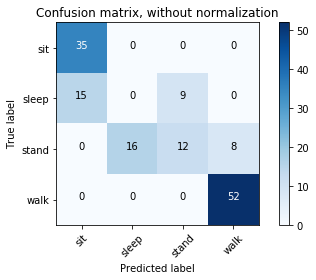

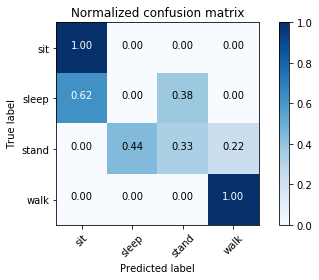

              precision    recall  f1-score   support

         sit       0.70      1.00      0.82        35
       sleep       0.00      0.00      0.00        24
       stand       0.57      0.33      0.42        36
        walk       0.87      1.00      0.93        52

   micro avg       0.67      0.67      0.67       147
   macro avg       0.53      0.58      0.54       147
weighted avg       0.61      0.67      0.63       147



In [88]:
acc = accuracy_score(all_labels_unseen, y_pred_unseen)
print(acc)

show_conf_matrix(all_labels_unseen, y_pred_unseen, label_list)
show_clf_report(all_labels_unseen, y_pred_unseen, label_list)

# To be deleted

In [ ]:
#     X_impure, y_impure = preprocess_data(df_acc, pca)
#     y_pred = predict_combine(X_impure, model)
#     p_periods = get_periods_from_list(y_pred, label_list)
#     pred_periods = {}

#     for i in range(len(label_list)):
#         pred_periods[label_list[i]] = p_periods[i]
    
#     pp_all = postprocess_predicted(pred_periods, len(y_pred))
    
#     p_true, len_true = sequence_from_periods(true_periods, label_list)
#     p_pred, len_pred = sequence_from_periods(pred_periods, label_list)
    
#     iou = evaluate_period(p_true, p_pred, len_pred, label_list)
    
#     print('label:', label_list)
#     print('iou:', iou)